In [7]:
pip install scikit-learn xgboost tensorflow-macos seaborn matplotlib pandas


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [9]:
import re
import ast
from pathlib import Path

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.tree import DecisionTreeClassifier

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df= pd.read_csv('/Users/jerry/Desktop/Personal Project/Dating App/Datraset/dating_app_behavior_dataset_extended1.csv')
print(df.columns.tolist())

['gender', 'sexual_orientation', 'location_type', 'income_bracket', 'education_level', 'interest_tags', 'app_usage_time_min', 'app_usage_time_label', 'swipe_right_ratio', 'swipe_right_label', 'likes_received', 'mutual_matches', 'profile_pics_count', 'bio_length', 'message_sent_count', 'emoji_usage_rate', 'last_active_hour', 'swipe_time_of_day', 'match_outcome', 'age', 'height_cm', 'weight_kg', 'zodiac_sign', 'body_type', 'relationship_intent']


In [12]:
total_rows= len(df)
print(total_rows)

50000


In [13]:
# Dataset shape
print(f"Total rows: {df.shape[0]}, Total columns: {df.shape[1]}")

# First 5 rows
print("\nFirst 5 records:")
print(df.head())


Total rows: 50000, Total columns: 25

First 5 records:
              gender sexual_orientation location_type income_bracket  \
0  Prefer Not to Say                Gay         Urban           High   
1               Male           Bisexual      Suburban   Upper-Middle   
2         Non-binary          Pansexual      Suburban            Low   
3        Genderfluid                Gay         Metro       Very Low   
4               Male           Bisexual         Urban         Middle   

       education_level                  interest_tags  app_usage_time_min  \
0           Bachelor’s   Fitness, Politics, Traveling                  52   
1  No Formal Education  Languages, Fashion, Parenting                 279   
2             Master’s           Movies, Reading, DIY                  49   
3              Postdoc      Coding, Podcasts, History                 185   
4           Bachelor’s       Clubbing, Podcasts, Cars                  83   

  app_usage_time_label  swipe_right_ratio swipe_r

In [14]:
# Data types
print("\nData types:")
print(df.dtypes)



Data types:
gender                   object
sexual_orientation       object
location_type            object
income_bracket           object
education_level          object
interest_tags            object
app_usage_time_min        int64
app_usage_time_label     object
swipe_right_ratio       float64
swipe_right_label        object
likes_received            int64
mutual_matches            int64
profile_pics_count        int64
bio_length                int64
message_sent_count        int64
emoji_usage_rate        float64
last_active_hour          int64
swipe_time_of_day        object
match_outcome            object
age                       int64
height_cm                 int64
weight_kg               float64
zodiac_sign              object
body_type                object
relationship_intent      object
dtype: object


In [15]:
# Summary statistics for numerical columns
print("\nSummary statistics (numerical):")
print(df.describe())



Summary statistics (numerical):
       app_usage_time_min  swipe_right_ratio  likes_received  mutual_matches  \
count        50000.000000       50000.000000    50000.000000    50000.000000   
mean           149.912400           0.500655       99.526040       13.870280   
std             86.990521           0.197468       57.996799        9.105615   
min              0.000000           0.000000        0.000000        0.000000   
25%             74.000000           0.370000       49.000000        6.000000   
50%            150.000000           0.500000      100.000000       13.000000   
75%            225.000000           0.640000      150.000000       22.000000   
max            300.000000           1.000000      200.000000       30.000000   

       profile_pics_count    bio_length  message_sent_count  emoji_usage_rate  \
count         50000.00000  50000.000000         50000.00000      50000.000000   
mean              2.98772    250.174400            50.07194          0.286205   
std

In [16]:
missing_count = df.isnull().sum()
missing_pct = (missing_count / len(df) * 100).round(2)

summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_pct
}).sort_values(by='Missing %', ascending=False)

print(summary)


                      Missing Count  Missing %
gender                            0        0.0
bio_length                        0        0.0
body_type                         0        0.0
zodiac_sign                       0        0.0
weight_kg                         0        0.0
height_cm                         0        0.0
age                               0        0.0
match_outcome                     0        0.0
swipe_time_of_day                 0        0.0
last_active_hour                  0        0.0
emoji_usage_rate                  0        0.0
message_sent_count                0        0.0
profile_pics_count                0        0.0
sexual_orientation                0        0.0
mutual_matches                    0        0.0
likes_received                    0        0.0
swipe_right_label                 0        0.0
swipe_right_ratio                 0        0.0
app_usage_time_label              0        0.0
app_usage_time_min                0        0.0
interest_tags


Target variable distribution (match_outcome):
                     Count  Percentage
match_outcome                         
One-sided Like        5112        10.2
Instant Match         5078        10.2
Blocked               5049        10.1
Catfished             5025        10.0
Chat Ignored          5019        10.0
Mutual Match          4990        10.0
No Action             4986        10.0
Ghosted               4959         9.9
Date Happened         4919         9.8
Relationship Formed   4863         9.7


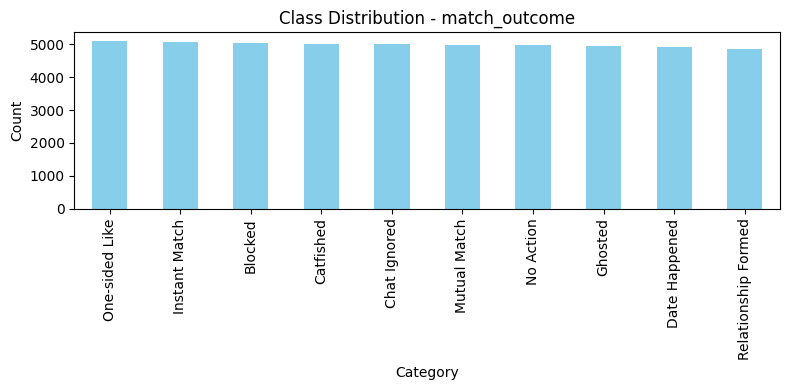

In [17]:
# Target variable distribution
# -------------------------------
target_col = 'match_outcome'
if target_col in df.columns:
    value_counts = df[target_col].value_counts()
    value_pct = df[target_col].value_counts(normalize=True).round(3) * 100
    target_summary = pd.DataFrame({
        'Count': value_counts,
        'Percentage': value_pct
    })
    print(f"\nTarget variable distribution ({target_col}):")
    print(target_summary)

    # Plot distribution
    plt.figure(figsize=(8, 4))
    value_counts.plot(kind='bar', color='skyblue')
    plt.title(f"Class Distribution - {target_col}")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


Correlation matrix (numeric features):
                    app_usage_time_min  swipe_right_ratio  likes_received  \
app_usage_time_min            1.000000           0.000490       -0.002879   
swipe_right_ratio             0.000490           1.000000       -0.004317   
likes_received               -0.002879          -0.004317        1.000000   
mutual_matches                0.008318           0.004139        0.205968   
profile_pics_count           -0.006816          -0.003321       -0.008693   
bio_length                    0.002045          -0.000201       -0.000149   
message_sent_count           -0.000944          -0.003280       -0.001074   
emoji_usage_rate              0.003504          -0.001835       -0.001523   
last_active_hour             -0.000377           0.000424        0.012123   
age                          -0.007839           0.005846       -0.003081   
height_cm                    -0.004232          -0.000469        0.008458   
weight_kg                     0.0002

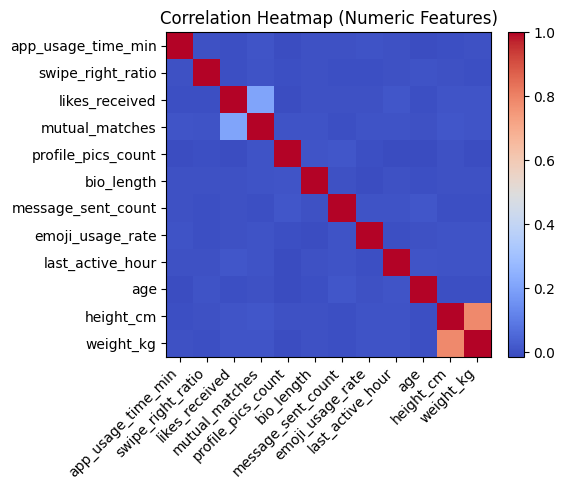

In [18]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    corr_matrix = df[numeric_cols].corr()

    print("\nCorrelation matrix (numeric features):")
    print(corr_matrix)

    plt.figure(figsize=(6, 5))
    im = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo numeric columns found for correlation analysis.")

In [19]:
CSV_PATH = "/Users/jerry/Desktop/Personal Project/Dating App/Datraset/dating_app_behavior_dataset_extended1.csv"
TARGET_COL = "match_outcome"

# Optional: choose scaler ("standard" or "minmax")
SCALER_KIND = "standard"

# Low-variance removal threshold (remove features with variance below this)
VARIANCE_THRESHOLD = 1e-5

# Model-based feature selection: keep features with importance >= median importance
MODEL_FS_THRESHOLD = "median"  # or use a float like 0.002

OUTPUT_DIR = Path("./prepared_data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [20]:

# Numeric columns (auto-detect)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Categorical columns (object dtype, excluding the multi-label text column)
text_multilabel_col = "interest_tags"
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
if text_multilabel_col in categorical_cols:
    categorical_cols.remove(text_multilabel_col)

# Ensure target is not in features
if TARGET_COL in categorical_cols:
    categorical_cols.remove(TARGET_COL)
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)
print("Multi-label text col:", text_multilabel_col)


Numeric cols: ['app_usage_time_min', 'swipe_right_ratio', 'likes_received', 'mutual_matches', 'profile_pics_count', 'bio_length', 'message_sent_count', 'emoji_usage_rate', 'last_active_hour', 'age', 'height_cm', 'weight_kg']
Categorical cols: ['gender', 'sexual_orientation', 'location_type', 'income_bracket', 'education_level', 'app_usage_time_label', 'swipe_right_label', 'swipe_time_of_day', 'zodiac_sign', 'body_type', 'relationship_intent']
Multi-label text col: interest_tags


In [21]:
# 3) Train/Val/Test split (stratified)
# -----------------------------
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype("category")  # keep as categorical labels for stratify; model will handle encoding later

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(0.15/0.30), random_state=42, stratify=y_temp
)

print("Split shapes:",
      "\n  Train:", X_train.shape,
      "\n  Val:  ", X_val.shape,
      "\n  Test: ", X_test.shape)

Split shapes: 
  Train: (35000, 24) 
  Val:   (7500, 24) 
  Test:  (7500, 24)


In [22]:
# 4) Helper: parse interest_tags into list
# -----------------------------
def parse_interest_tags(x):
    """
    Parse interest_tags into a list of strings.
    Supports formats like:
      - "Fitness, Traveling, Politics"
      - "['Fitness', 'Traveling']"
    """
    if pd.isna(x):
        return []
    s = str(x).strip()
    # Try literal list
    if s.startswith("[") and s.endswith("]"):
        try:
            lst = ast.literal_eval(s)
            return [str(v).strip() for v in lst]
        except Exception:
            pass
    # Fallback: split by comma/semicolon
    parts = [p.strip() for p in re.split(r",|;", s) if p.strip()]
    return parts

In [23]:
# Fit MultiLabelBinarizer on TRAIN ONLY to avoid leakage
mlb = MultiLabelBinarizer(sparse_output=False)

def fit_transform_tags(series_train):
    tag_lists = series_train.apply(parse_interest_tags)
    Z_train = mlb.fit_transform(tag_lists)
    tag_cols = [f"tag_{t}" for t in mlb.classes_]
    return pd.DataFrame(Z_train, columns=tag_cols, index=series_train.index)

def transform_tags(series):
    tag_lists = series.apply(parse_interest_tags)
    Z = mlb.transform(tag_lists)
    tag_cols = [f"tag_{t}" for t in mlb.classes_]
    return pd.DataFrame(Z, columns=tag_cols, index=series.index)


In [24]:
# Build tag matrices
Z_train = fit_transform_tags(X_train[text_multilabel_col]) if text_multilabel_col in X_train.columns else pd.DataFrame(index=X_train.index)
Z_val   = transform_tags(X_val[text_multilabel_col])       if text_multilabel_col in X_val.columns   else pd.DataFrame(index=X_val.index)
Z_test  = transform_tags(X_test[text_multilabel_col])      if text_multilabel_col in X_test.columns  else pd.DataFrame(index=X_test.index)

In [25]:
# Drop the raw text column from X
for split_df in (X_train, X_val, X_test):
    if text_multilabel_col in split_df.columns:
        split_df.drop(columns=[text_multilabel_col], inplace=True)

In [26]:
#  5) Missing values & Outlier capping for numeric
#    - Impute numeric with mean (fit on TRAIN)
#    - Cap outliers using IQR (fit on TRAIN, apply to all)
# -----------------------------
# Impute numeric
num_imputer = SimpleImputer(strategy="mean")
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[numeric_cols]),
                           columns=numeric_cols, index=X_train.index)
X_val_num   = pd.DataFrame(num_imputer.transform(X_val[numeric_cols]),
                           columns=numeric_cols, index=X_val.index)
X_test_num  = pd.DataFrame(num_imputer.transform(X_test[numeric_cols]),
                           columns=numeric_cols, index=X_test.index)

# IQR capping (winsorization) learned on TRAIN
def fit_iqr_caps(df_num):
    caps = {}
    for col in df_num.columns:
        q1 = df_num[col].quantile(0.25)
        q3 = df_num[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        caps[col] = (lower, upper)
    return caps

def apply_caps(df_num, caps):
    df_capped = df_num.copy()
    for col, (lo, up) in caps.items():
        df_capped[col] = df_capped[col].clip(lower=lo, upper=up)
    return df_capped

iqr_caps = fit_iqr_caps(X_train_num)
X_train_num = apply_caps(X_train_num, iqr_caps)
X_val_num   = apply_caps(X_val_num, iqr_caps)
X_test_num  = apply_caps(X_test_num, iqr_caps)

# -----------------------------
# 6) Missing values for categorical + One-Hot (fit on TRAIN)
# -----------------------------
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_cols]),
                               columns=categorical_cols, index=X_train.index)
X_val_cat_imp   = pd.DataFrame(cat_imputer.transform(X_val[categorical_cols]),
                               columns=categorical_cols, index=X_val.index)
X_test_cat_imp  = pd.DataFrame(cat_imputer.transform(X_test[categorical_cols]),
                               columns=categorical_cols, index=X_test.index)

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_cat_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat_imp),
                               columns=ohe.get_feature_names_out(categorical_cols),
                               index=X_train.index)
X_val_cat_ohe   = pd.DataFrame(ohe.transform(X_val_cat_imp),
                               columns=ohe.get_feature_names_out(categorical_cols),
                               index=X_val.index)
X_test_cat_ohe  = pd.DataFrame(ohe.transform(X_test_cat_imp),
                               columns=ohe.get_feature_names_out(categorical_cols),
                               index=X_test.index)

# -----------------------------
# 7) Combine: numeric + one-hot categorical + tag binaries
# -----------------------------
X_train_full = pd.concat([X_train_num, X_train_cat_ohe, Z_train], axis=1)
X_val_full   = pd.concat([X_val_num,   X_val_cat_ohe,   Z_val], axis=1)
X_test_full  = pd.concat([X_test_num,  X_test_cat_ohe,  Z_test], axis=1)

print("Feature matrix shapes:",
      "\n  Train:", X_train_full.shape,
      "\n  Val:  ", X_val_full.shape,
      "\n  Test: ", X_test_full.shape)

# -----------------------------

Feature matrix shapes: 
  Train: (35000, 138) 
  Val:   (7500, 138) 
  Test:  (7500, 138)


In [27]:
if SCALER_KIND == "minmax":
    scaler = MinMaxScaler()
else:
    scaler = StandardScaler(with_mean=True, with_std=True)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_full),
                              columns=X_train_full.columns, index=X_train_full.index)
X_val_scaled   = pd.DataFrame(scaler.transform(X_val_full),
                              columns=X_val_full.columns, index=X_val_full.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test_full),
                              columns=X_test_full.columns, index=X_test_full.index)


In [28]:
# 9) Low-variance feature removal (fit on TRAIN)
# -----------------------------
vt = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
X_train_vt = pd.DataFrame(vt.fit_transform(X_train_scaled),
                          columns=X_train_scaled.columns[vt.get_support()],
                          index=X_train_scaled.index)
X_val_vt   = pd.DataFrame(vt.transform(X_val_scaled),
                          columns=X_train_scaled.columns[vt.get_support()],
                          index=X_val_scaled.index)
X_test_vt  = pd.DataFrame(vt.transform(X_test_scaled),
                          columns=X_train_scaled.columns[vt.get_support()],
                          index=X_test_scaled.index)

print("After VarianceThreshold:",
      "\n  Train:", X_train_vt.shape,
      "\n  Val:  ", X_val_vt.shape,
      "\n  Test: ", X_test_vt.shape)


After VarianceThreshold: 
  Train: (35000, 138) 
  Val:   (7500, 138) 
  Test:  (7500, 138)


In [29]:
# ================================
# Save final processed datasets (after VarianceThreshold)
# ================================
from pathlib import Path
import pandas as pd

# Output directory
out_dir = Path("./prepared_data")
out_dir.mkdir(parents=True, exist_ok=True)

# Save features
X_train_vt.to_csv(out_dir / "X_train.csv", index=True)
X_val_vt.to_csv(out_dir / "X_val.csv", index=True)
X_test_vt.to_csv(out_dir / "X_test.csv", index=True)

# Save labels (if categorical, save both raw and encoded)
def label_df(y):
    if hasattr(y, "cat"):
        return pd.DataFrame({
            "y_raw": y.astype(str).values,
            "y_enc": y.cat.codes.values
        }, index=y.index)
    else:
        return pd.DataFrame({"y_raw": y.values}, index=y.index)

label_df(y_train).to_csv(out_dir / "y_train.csv")
label_df(y_val).to_csv(out_dir / "y_val.csv")
label_df(y_test).to_csv(out_dir / "y_test.csv")

# Save metadata
meta = {
    "n_features": X_train_vt.shape[1],
    "feature_names": X_train_vt.columns.tolist(),
    "split_sizes": {
        "train": len(y_train),
        "val": len(y_val),
        "test": len(y_test)
    }
}
pd.Series(meta, dtype="object").to_json(out_dir / "metadata.json")

print("Final processed datasets saved to:", out_dir.resolve())


Final processed datasets saved to: /Users/jerry/prepared_data


In [30]:
# 1) Load data
# -----------------------
data_dir = Path("./prepared_data")
X_train = pd.read_csv(data_dir / "X_train.csv", index_col=0)
X_val   = pd.read_csv(data_dir / "X_val.csv", index_col=0)
X_test  = pd.read_csv(data_dir / "X_test.csv", index_col=0)

y_train_df = pd.read_csv(data_dir / "y_train.csv", index_col=0)
y_val_df   = pd.read_csv(data_dir / "y_val.csv", index_col=0)
y_test_df  = pd.read_csv(data_dir / "y_test.csv", index_col=0)

In [31]:
# Use encoded labels for modeling
y_train_enc = y_train_df["y_enc"].values
y_val_enc   = y_val_df["y_enc"].values
y_test_enc  = y_test_df["y_enc"].values


In [32]:
# For ROC, we need binary matrix form
classes = sorted(np.unique(y_train_enc))
n_classes = len(classes)
y_test_bin = label_binarize(y_test_enc, classes=classes)


In [33]:
# 2) Logistic Regression
# -----------------------
log_reg = LogisticRegression(max_iter=500, multi_class="multinomial", solver="lbfgs", n_jobs=-1)
log_reg.fit(X_train, y_train_enc)
y_pred_lr = log_reg.predict(X_test)

print("\n=== Logistic Regression ===")
print(classification_report(y_test_enc, y_pred_lr, digits=3))

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.101     0.103     0.102       757
           1      0.099     0.101     0.100       753
           2      0.100     0.113     0.106       753
           3      0.089     0.081     0.085       738
           4      0.099     0.089     0.094       744
           5      0.101     0.109     0.105       762
           6      0.090     0.111     0.099       749
           7      0.101     0.079     0.089       748
           8      0.116     0.123     0.119       767
           9      0.092     0.080     0.085       729

    accuracy                          0.099      7500
   macro avg      0.099     0.099     0.098      7500
weighted avg      0.099     0.099     0.099      7500



In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np

dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42
)
dt.fit(X_train, y_train_enc)
y_pred_dt = dt.predict(X_test)

print("\n=== Decision Tree ===")
print("Accuracy:", round(accuracy_score(y_test_enc, y_pred_dt), 4))
print("Macro-F1:", round(f1_score(y_test_enc, y_pred_dt, average="macro"), 4))
print(classification_report(y_test_enc, y_pred_dt, digits=3))




=== Decision Tree ===
Accuracy: 0.0961
Macro-F1: 0.0943
              precision    recall  f1-score   support

           0      0.087     0.094     0.090       757
           1      0.126     0.097     0.109       753
           2      0.107     0.096     0.101       753
           3      0.083     0.084     0.083       738
           4      0.098     0.071     0.082       744
           5      0.093     0.093     0.093       762
           6      0.095     0.187     0.126       749
           7      0.088     0.060     0.071       748
           8      0.098     0.087     0.092       767
           9      0.095     0.092     0.093       729

    accuracy                          0.096      7500
   macro avg      0.097     0.096     0.094      7500
weighted avg      0.097     0.096     0.094      7500



In [35]:
# === MLP (Keras) ===
input_dim = X_train.shape[1]
n_classes = len(np.unique(y_train_enc))

mlp = Sequential([
    Dense(256, activation="relu", input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(n_classes, activation="softmax"),
])
mlp.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

y_train_cat = to_categorical(y_train_enc, num_classes=n_classes)
y_val_cat   = to_categorical(y_val_enc,   num_classes=n_classes)

es = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, restore_best_weights=True)

mlp.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=40, batch_size=256, verbose=1,
    callbacks=[es]
)

y_pred_mlp = np.argmax(mlp.predict(X_test, verbose=0), axis=1)

print("\n=== MLP ===")
print("Accuracy:", round(accuracy_score(y_test_enc, y_pred_mlp), 4))
print("Macro-F1:", round(f1_score(y_test_enc, y_pred_mlp, average="macro"), 4))
print(classification_report(y_test_enc, y_pred_mlp, digits=3))

Epoch 1/40


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1040 - loss: 2.4196 - val_accuracy: 0.0995 - val_loss: 2.3040
Epoch 2/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1094 - loss: 2.3015 - val_accuracy: 0.0975 - val_loss: 2.3035
Epoch 3/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1163 - loss: 2.2978 - val_accuracy: 0.0964 - val_loss: 2.3043
Epoch 4/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1202 - loss: 2.2940 - val_accuracy: 0.0940 - val_loss: 2.3059
Epoch 5/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1259 - loss: 2.2888 - val_accuracy: 0.0944 - val_loss: 2.3065
Epoch 6/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1333 - loss: 2.2838 - val_accuracy: 0.0995 - val_loss: 2.3088

=== MLP ===
Accuracy: 0.1
Macro-F1: 0.0926
              precision    recall  f1-score   support

           0      0.109     0.239     0.149       757
           1      0.095     0.054     0.069       753
           2      0.087     0.061   